# Faça upload de suas amostras e execute o ambiente

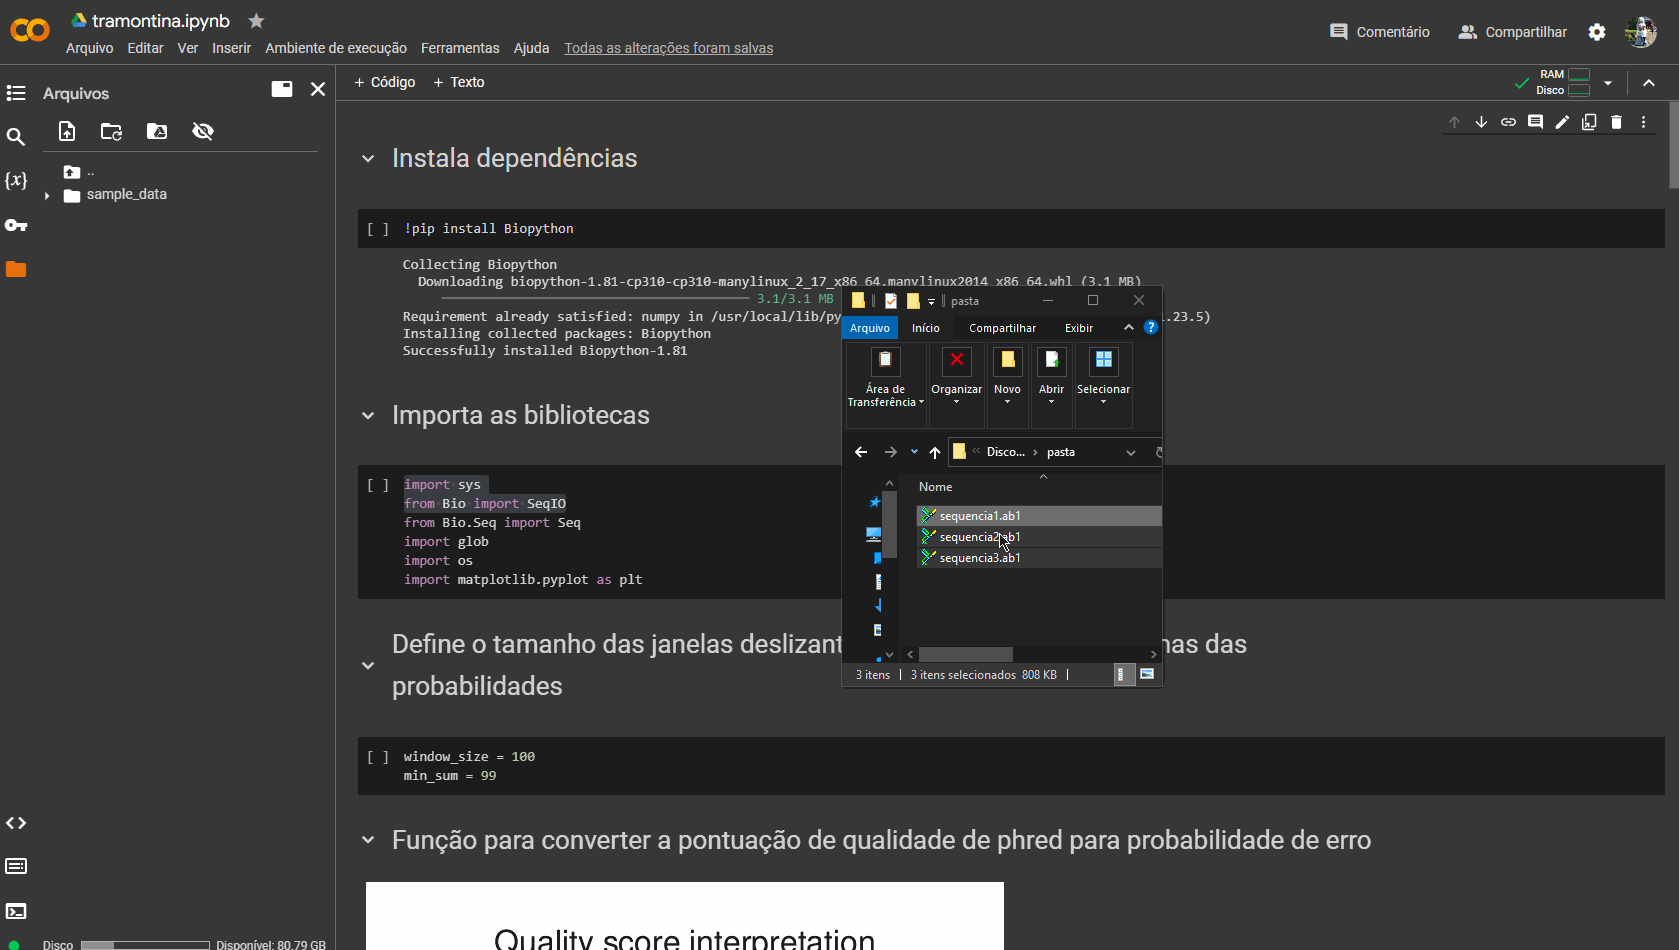

# Instala dependências

In [1]:
!pip install Biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 20.4 MB/s eta 0:00:00


# Importa as bibliotecas

In [2]:
import sys
from Bio import SeqIO
from Bio.Seq import Seq
import glob
import os
import matplotlib.pyplot as plt

# Define o tamanho das janelas deslizantes e qual a o cutoff das somas das probabilidades

In [3]:
window_size = 100
min_sum = 99

# Função para converter a pontuação de qualidade de phred para probabilidade de erro

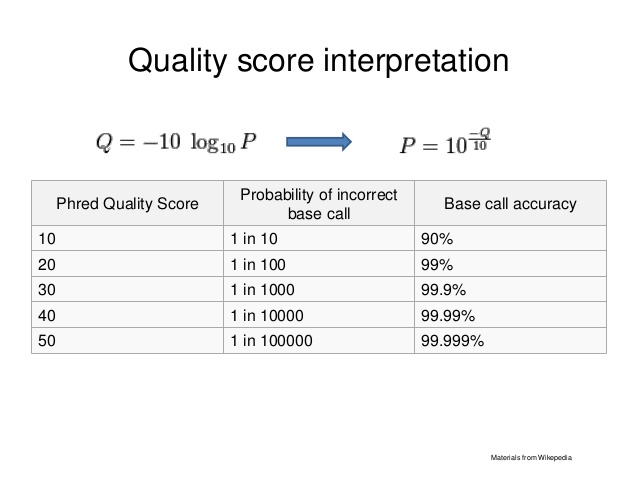

In [4]:
def phred_to_probability(phred_score):
    return (10 ** ((phred_score) / -10.0)) * 100

# Função para converter a pontuação de qualidade de phred para probabilidade de erro para cada base da sequência

In [5]:
def scores_to_error_probabilities(quality_scores):
    return [phred_to_probability(score) for score in quality_scores]

# Função para cortar a sequência de acordo com a probabilidade de erro dentro de uma janela deslizante

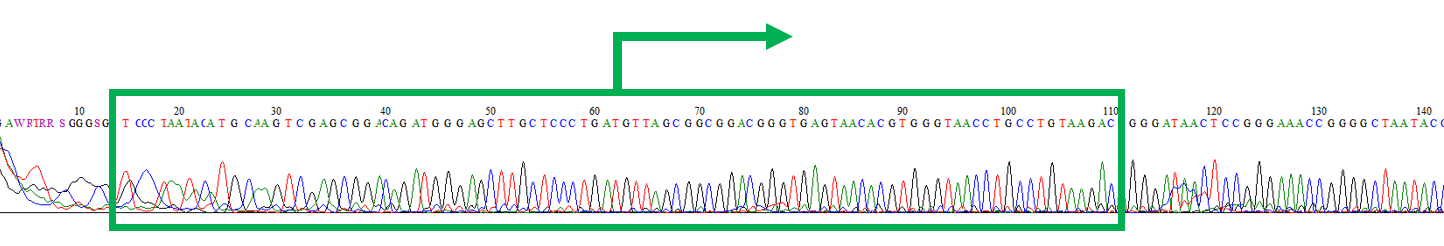

In [6]:
def cut_sequence_by_error_probability(ab1_file, window_size, min_sum):
    quality = SeqIO.read(ab1_file, "abi").letter_annotations["phred_quality"]
    error_probabilities = scores_to_error_probabilities(quality)

    # Calcula a soma das probabilidades de erro dentro de uma janela deslizante
    sum_window = sum(error_probabilities[:window_size])

    # Encontra o início e o fim do corte
    start, end = 0, len(error_probabilities)

    # Encontra o início do corte
    for i in range(window_size, len(error_probabilities)):
        if sum_window < min_sum:
            start = i - window_size
            break
        sum_window += error_probabilities[i] - error_probabilities[i - window_size]

    # Somas das probabilidades de erro dentro de uma janela deslizante, mas em ordem reversa
    error_probabilities_reverse = error_probabilities[::-1]
    sum_window_reverse = sum(error_probabilities_reverse[:window_size])

    # Encontra o fim do corte
    for i in range(window_size, len(error_probabilities_reverse)):
        if sum_window_reverse < min_sum:
            end = len(error_probabilities) - i + window_size -1
            break
        sum_window_reverse += error_probabilities_reverse[i] - error_probabilities_reverse[i - window_size]

    # Corta a sequência de acordo com o início e o fim do corte encontrados anteriormente
    record = SeqIO.read(ab1_file, "abi")
    record = record[start:end]

    # Pega o nome do arquivo .ab1 e seta o nome da pasta de saída
    base_filename = os.path.splitext(os.path.basename(ab1_file))[0]
    output_folder = f"{base_filename}"

    # Cria uma pasta para armazenar os resultados
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Salva a sequência cortada em um arquivo .fasta na pasta de saída criada anteriormente
    fasta_file = f"{output_folder}/{base_filename}_cut.fasta"
    SeqIO.write(record, fasta_file, "fasta")

    # Retorna o início e o fim do corte, além do nome da pasta de saída
    return start, end, output_folder

# Função para plotar a probabilidade de erro ao longo da sequência

In [7]:
def plot_error_probabilities(ab1_file, start, end, output_folder):

    # Lê o arquivo .ab1 e pega a pontuação de qualidade de phred para cada base da sequência
    quality = SeqIO.read(ab1_file, "abi").letter_annotations["phred_quality"]
    error_probabilities = scores_to_error_probabilities(quality)

    # Plota a probabilidade de erro ao longo da sequência
    plt.figure(figsize=(10, 6))
    plt.plot(error_probabilities, color='blue', linestyle='-', linewidth=1.5)  # Alteração aqui

    # Plota uma linha vertical vermelha no início do corte e uma linha vertical verde no fim do corte
    plt.axvline(x=start, color='red', linestyle='--', label='Início do corte')
    plt.axvline(x=end, color='green', linestyle='--', label='Fim do corte')

    # Cria o título e os labels do gráfico
    plt.title('Probabilidade de erro ao longo da sequência')
    plt.xlabel('Posição na sequência')
    plt.ylabel('Probabilidade de erro')
    plt.legend()
    base_filename = os.path.splitext(os.path.basename(ab1_file))[0]
    plot_filename = f"{output_folder}/{base_filename}_error_probabilities_plot.png"
    plt.savefig(plot_filename)
    plt.show()


# Função para processar as subpastas com arquivos .fasta

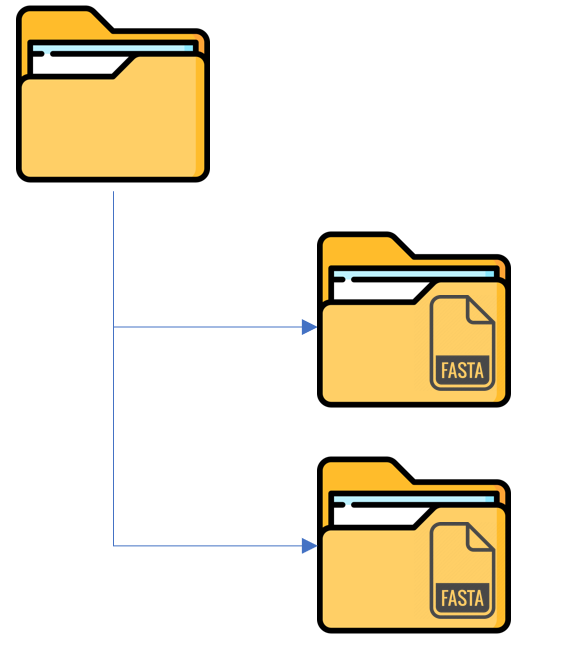

In [8]:
def processa_subpastas_com_fasta():
    for pasta_atual, subpastas, _ in os.walk('.'):
        for subpasta in subpastas:
            pasta_com_fasta = os.path.join(pasta_atual, subpasta)
            arquivos_fasta = glob.glob(os.path.join(pasta_com_fasta, '*.fasta'))

            for fasta_file in arquivos_fasta:
                with open(fasta_file, "r") as fasta_handle:
                    for record in SeqIO.parse(fasta_handle, "fasta"):
                        sequence = str(record.seq)  # Define a sequência a partir do registro atual

                        regioes = verifica_regioes_primers(sequence, primers)

                        for regiao_nome, sequencia_regiao in regioes.items():
                            nome_arquivo_regiao = f'{os.path.splitext(os.path.basename(fasta_file))[0]}_{regiao_nome}.fasta'
                            caminho_arquivo_regiao = os.path.join(pasta_com_fasta, nome_arquivo_regiao)

                            # Obtém o início e fim dos primers F e R
                            start_F = sequence.find(primers[regiao_nome + "_F"])
                            end_R = sequence.find(primers[regiao_nome + "_R"], start_F + 1)  # Procura o primer R após o F

                            # Escreve a sequência entre os primers F e R no arquivo .fasta
                            sequencia_entre_primers = sequence[start_F + len(primers[regiao_nome + "_F"]):end_R]

                            with open(caminho_arquivo_regiao, "w") as output_handle:
                                output_handle.write(f'>{regiao_nome}\n{sequencia_entre_primers}\n')

# Define os primers

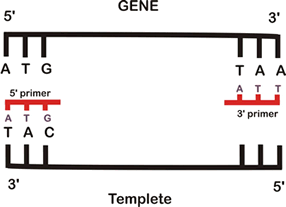

In [9]:
primers = {
    'V4_F': 'CACYGTCGMCGGCGCCATT', 'V4_R': 'CCTGATGNVCCCAWAGATTA',
    'V4-V5_F': 'CACYGTCGMCGGCGCCATT', 'V4-V5_R': 'GGCYGTTAAGMAAARTCAAA',
    'V3-V4_F': 'GGATGCCCNCCGWCGTC', 'V3-V4_R': 'CTGATGHVCCCATAGATTAGG',
    'V1-V2-V3_F': 'TCTCAAACTAGMACCGAGTC', 'V1-V2-V3_R': 'WAATGGCGCCGACGACC',
    'V1-V2_F': 'CTCAAACTAGNACCGAGTC', 'V1-V2_R': 'ACGACGGAGGGCATCCTCA',
    'V3_F': 'GGATGCCCTCCGTCGTC', 'V3_R': 'TAATGGCGCCGACGACC'
}

# Função para substituir caracteres coringa
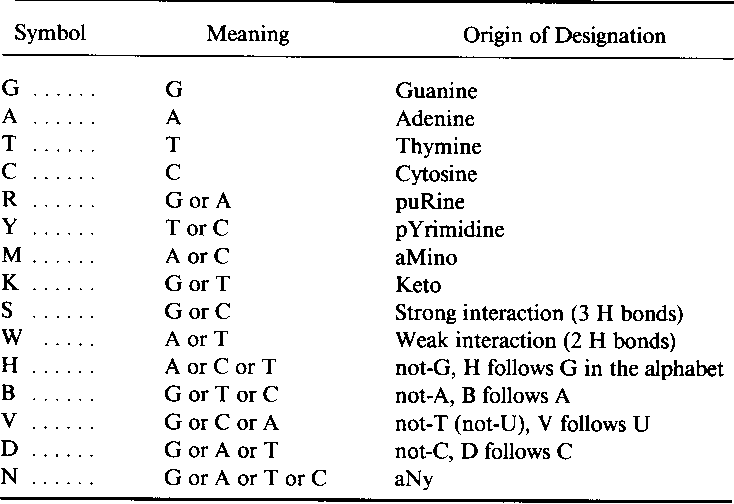

In [10]:
def substitui_primers(sequencia):
    """
    Gera todas as combinações possíveis substituindo caracteres coringa
    """
    trocas = {'M': ['A', 'C'], 'Y': ['C', 'T'], 'N': ['A', 'C', 'T', 'G'],
              'W': ['A', 'T'], 'R': ['A', 'G'], 'H': ['A', 'C', 'T'], 'V': ['A', 'C', 'G']}
    sequencias = [sequencia]

    for trocas, substitutions in trocas.items():
        novas_sequencias = []
        for s in sequencias:
            for substitution in substitutions:
                nova_sequencia = s.replace(trocas, substitution)
                novas_sequencias.append(nova_sequencia)
        sequencias = novas_sequencias

    return sequencias

# Função para verificar se os primers estão presentes na sequência

In [11]:
def verifica_regioes_primers(sequencia, primers):
    regioes_encontradas = {}

    for primer_name, primer_sequence in primers.items():
        if primer_name.endswith('_F') or primer_name.endswith('_R'):
            # Remove sufixo para encontrar a correspondência entre F e R
            chave_primer = primer_name.rstrip("_FR")

            # Gera todas as combinações possíveis substituindo caracteres coringa
            primer_sequences = substitui_primers(primer_sequence)

            for p_sequence in primer_sequences:
                start = sequencia.find(p_sequence)
                if start != -1:
                    primer_correspondente = f'{chave_primer}_R' if primer_name.endswith('_F') else f'{chave_primer}_F'
                    corresponding_sequence = primers[primer_correspondente]

                    end = sequencia.find(corresponding_sequence)
                    if end != -1:
                        regiao = sequencia[start+len(p_sequence):end]

                        regioes_encontradas[chave_primer] = regiao

    return regioes_encontradas

# Executa o código para cada arquivo enviado para ca

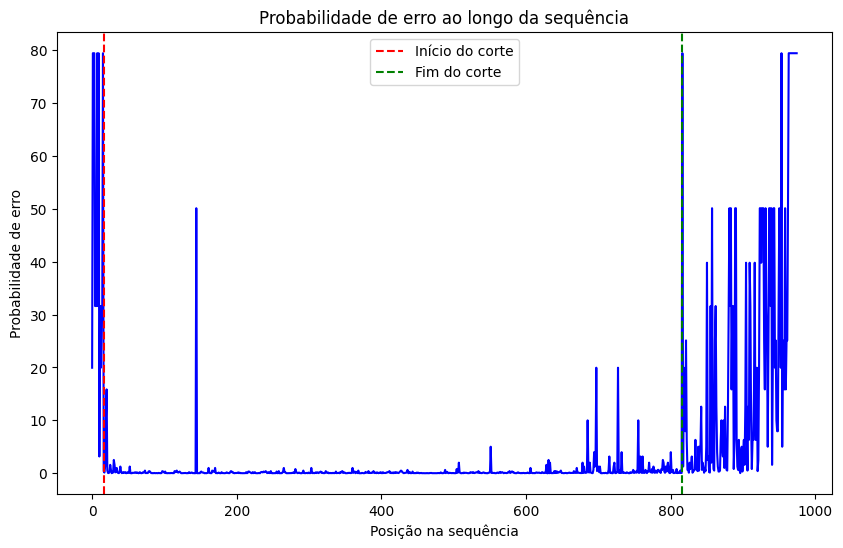

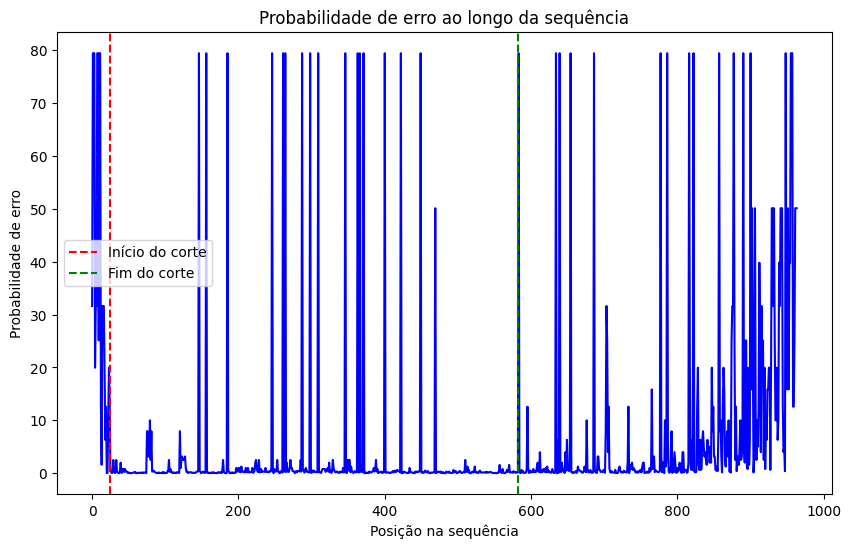

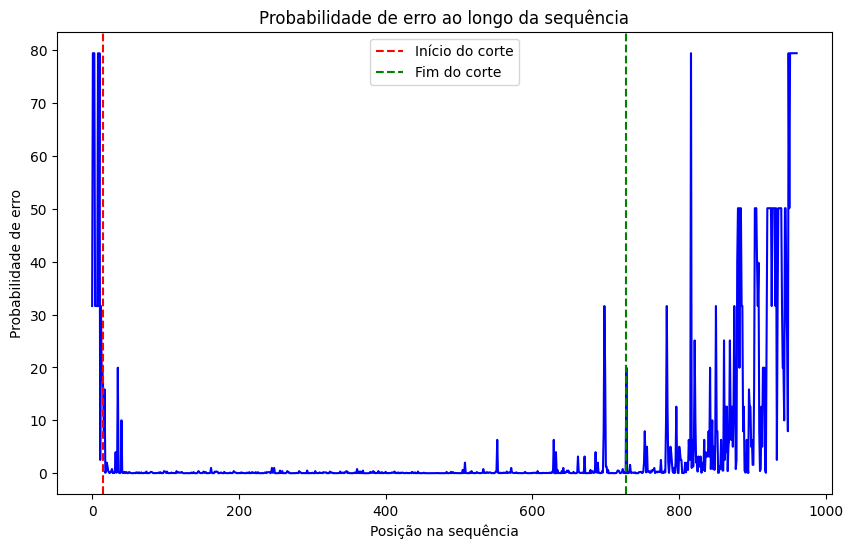

In [12]:
ab1_files = glob.glob("*.ab1")

for ab1_file in ab1_files:
    start, end, output_folder = cut_sequence_by_error_probability(ab1_file, window_size, min_sum)
    plot_error_probabilities(ab1_file, start, end, output_folder)

    # Realize o processamento dos arquivos .fasta gerados com a função processa_subpastas_com_fasta
    processa_subpastas_com_fasta()